In [5]:
# Import libraries + data
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.utils import resample
from bees_lifetimetracking_2018data import definitions2024 as bn

data = pd.DataFrame()
for day in range(0, 50):
    newData = pd.read_csv(f'day{day}.csv')
    data = pd.concat([data, newData])

# Tidying
result = data.drop(columns=['Unnamed: 0'])

# DF ready for analysis!
result = result.sort_values(by=['uid', 'datetime'])
result = result[['uid', 'Age', 'Day (Seasonal Cycle)', 'YYYYMMDD', 'Second (Daily Cycle)', 'HHMMSS', 'mins_since_df_visit', 'status']]
result = result.drop_duplicates()
result

,uid,Age,Day (Seasonal Cycle),YYYYMMDD,Second (Daily Cycle),HHMMSS,mins_since_df_visit,status
0,402,20.0,0,20180716,68702,190502,-1,no change
1,402,20.0,0,20180716,68704,190504,-1,no change
2,402,20.0,0,20180716,68709,190509,-1,no change
3,402,20.0,0,20180716,68711,190511,-1,no change
4,402,20.0,0,20180716,68713,190513,-1,no change
...,...,...,...,...,...,...,...,...
6462181,5342,5.0,49,20180903,86273,235753,2396,no change
6462182,5342,5.0,49,20180903,86277,235757,2397,no change
6462183,5342,5.0,49,20180903,86278,235758,2398,no change
6462184,5342,5.0,49,20180903,86279,235759,2399,no change


In [11]:
result.status.value_counts()

status
no change    218534341
leave            19589
Name: count, dtype: int64

In [13]:
# Balancing data
df = pd.concat([
    resample(result[result['status'] == 'no change'], n_samples=result.status.value_counts()[1], random_state=42),
    result[result['status'] == 'leave']
]).sample(frac=1, random_state=42).reset_index(drop=True)
df.status.value_counts()

/var/folders/n0/1cczvx7j28x3rr7vsk304gy80000gq/T/ipykernel_11517/93474185.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  resample(result[result['status'] == 'no change'], n_samples=result.status.value_counts()[1], random_state=42),


status
leave        19589
no change    19589
Name: count, dtype: int64

In [15]:
# quick switch from no change and leave to 0 and 1
df['status'] = df['status'].map({'no change': 0, 'leave': 1})

# Split Train and Test Data
from sklearn.model_selection import train_test_split

y = df['status']
X = df[['Age','Day (Seasonal Cycle)', 'Second (Daily Cycle)', 'mins_since_df_visit']]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=25)

In [17]:
df.to_csv('df.csv')

In [19]:
# more libraries
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
import seaborn as sns
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
# snatched straight from Padma <3
def model_performance(model,x_train,x_test, y_train,y_test):
    print(f"{model} Performance:\n")
    
    y_pred = model.predict(x_test)
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    sns.set(rc = {'figure.figsize':(6,4)})
    sns.heatmap(cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 2, linecolor='black', clip_on = False, cbar = False, annot_kws = {'fontsize': 15}, 
    yticklabels = ['No Forage', 'Forage'], xticklabels = ['Predicted no forage', 'Predicted forage'])
    plt.show()
   
    
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    accuracy = accuracy_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred)

    cross_val_score_insample = cross_val_score(model,x_train,y_train,cv=5,scoring='accuracy').mean()
    cross_val_score_outsample = cross_val_score(model,x_test,y_test,cv=5,scoring='accuracy').mean()
    
    print('Precision Score:',precision)
    print("Recall Score:",recall)
    print("Accuracy Score:",accuracy)
    print('F1 Score:',f1)
    print("Cross Val Score Insample",cross_val_score_insample)
    print("Cross Val Score Outsample",cross_val_score_outsample)
    
    return model,precision,recall,accuracy,cross_val_score_insample,cross_val_score_outsample

## Naive Bayes

GaussianNB() Performance:



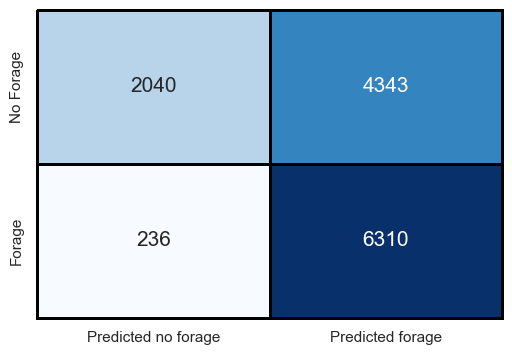

Precision Score: 0.5923214118088801
Recall Score: 0.9639474488237091
Accuracy Score: 0.6458349446979658
F1 Score: 0.733763590906448
Cross Val Score Insample 0.6389194349944207
Cross Val Score Outsample 0.6432054463776831


In [27]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

performance_nb = model_performance(gnb, X_train, X_test, y_train, y_test)

## KNN

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn_temp_model = KNeighborsClassifier()
param_grid={'weights' : ['uniform','distance'],'n_neighbors' : (np.arange(9)+2)}
knn_grid = GridSearchCV(knn_temp_model,param_grid,cv=5,scoring='accuracy',verbose=1)
grid_results = knn_grid.fit(X_train,y_train)
best_k = knn_grid.best_params_['n_neighbors']
print("\t Ideal K-Val: {}".format(best_k))
print("\t Accuracy of Tuned Training Data: {:.2f}%".format(grid_results.best_score_ * 100))

Fitting 5 folds for each of 18 candidates, totalling 90 fits
	 Ideal K-Val: 9
	 Accuracy of Tuned Training Data: 74.49%


KNeighborsClassifier(n_neighbors=9) Performance:



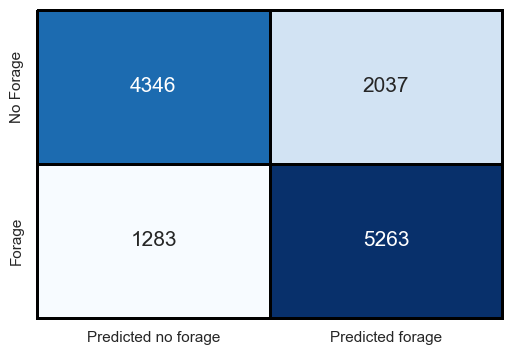

Precision Score: 0.7209589041095891
Recall Score: 0.8040024442407577
Accuracy Score: 0.7432129321679944
F1 Score: 0.7602195579950888
Cross Val Score Insample 0.7449427573506064
Cross Val Score Outsample 0.7340097025943894


In [31]:
knn_model = KNeighborsClassifier(n_neighbors=best_k)
knn_model.fit(X_train, y_train)
performance_knn = model_performance(knn_model,X_train, X_test, y_train, y_test)

## Logistic Regression

Number of mislabeled points out of a total 12929 points : 3660
LogisticRegression() Performance:



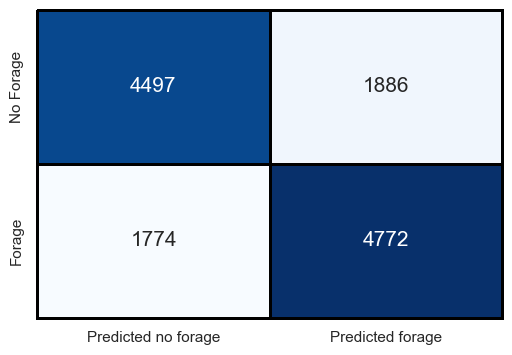

Precision Score: 0.7167317512766597
Recall Score: 0.7289948059883898
Accuracy Score: 0.7169154613659215
F1 Score: 0.7228112693123296
Cross Val Score Insample 0.7156084587540483
Cross Val Score Outsample 0.7169162324733238


In [33]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=100)
y_pred = lr.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))
performance_lr = model_performance(lr,X_train, X_test, y_train, y_test)

## Random Forest

Number of mislabeled points out of a total 12929 points : 2463
RandomForestClassifier() Performance:



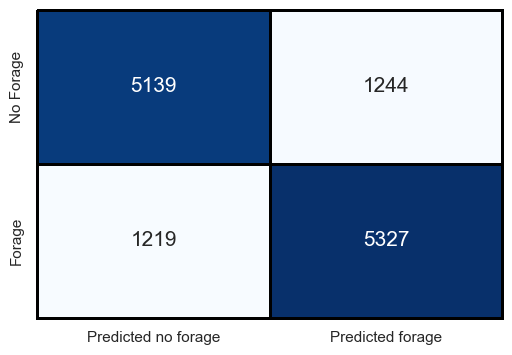

Precision Score: 0.810683305432963
Recall Score: 0.8137794072716162
Accuracy Score: 0.8094980276896898
F1 Score: 0.812228405885492
Cross Val Score Insample 0.8155357882226999
Cross Val Score Outsample 0.8075647924174361


In [35]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
y_pred = rfc.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))
performance_rfc = model_performance(rfc,X_train, X_test, y_train, y_test)

                Feature  Gini Importance
3   mins_since_df_visit         0.476286
2  Second (Daily Cycle)         0.257420
0                   Age         0.154380
1  Day (Seasonal Cycle)         0.111914


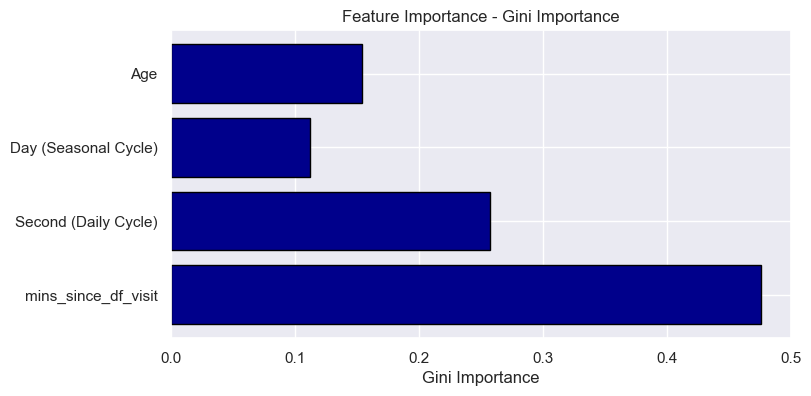

In [47]:
feature_names = X.columns
importances = rfc.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False) 
print(feature_imp_df)

# Create a bar plot for feature importance
plt.figure(figsize=(8, 4))
plt.barh(feature_names, importances, color='darkblue', edgecolor='black')
plt.xlabel('Gini Importance')
plt.title('Feature Importance - Gini Importance')
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()

In [50]:
'''from sklearn.ensemble import RandomForestClassifier

yUnbalanced = df_unbalanced['status']
XUnbalanced = df_unbalanced[['Age','Day (Seasonal Cycle)', 'Second (Daily Cycle)', 'mins_since_df_visit']]

rfc = RandomForestClassifier()
y_pred = rfc.fit(X_train, y_train).predict(XUnbalanced)
print("Number of mislabeled points out of a total %d points : %d" % (XUnbalanced.shape[0], (yUnbalanced != y_pred).sum()))
performance_rfc = model_performance(rfc, X_train, XUnbalanced, y_train, yUnbalanced)
'''

'from sklearn.ensemble import RandomForestClassifier\n\nyUnbalanced = df_unbalanced[\'status\']\nXUnbalanced = df_unbalanced[[\'Age\',\'Day (Seasonal Cycle)\', \'Second (Daily Cycle)\', \'mins_since_df_visit\']]\n\nrfc = RandomForestClassifier()\ny_pred = rfc.fit(X_train, y_train).predict(XUnbalanced)\nprint("Number of mislabeled points out of a total %d points : %d" % (XUnbalanced.shape[0], (yUnbalanced != y_pred).sum()))\nperformance_rfc = model_performance(rfc, X_train, XUnbalanced, y_train, yUnbalanced)\n'

## SVM

Number of mislabeled points out of a total 12929 points : 3891
SVC(kernel='linear') Performance:



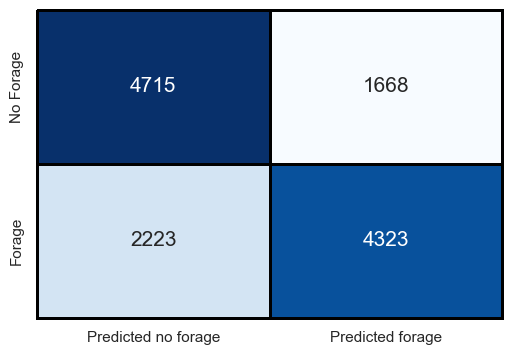

Precision Score: 0.7215823735603405
Recall Score: 0.6604032997250229
Accuracy Score: 0.6990486503209838
F1 Score: 0.689638669538167
Cross Val Score Insample 0.7008653983978809
Cross Val Score Outsample 0.7053920156294644


In [53]:
from sklearn.svm import SVC

svm = SVC(kernel = 'linear')
y_pred = svm.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))
performance_svm = model_performance(svm,X_train, X_test, y_train, y_test)

- include rest of days
- analysis for factors individually + weights
- neural network (include variation in parameters/process)
- try grid method for random forest+similar, not just knn